# Neural Network (nn)

[Edward Lu](https://github.com/edwardlu71/notebooks)

### Convolutional Neural Network

- a class of deep neural network
- each neuron in one layer is connected to all neurons in the next layer, multilayer perceptrons
- multiple hidden layers, the hidden layers of a CNN typically consist of a series of convolutional layers that convolve with a multiplication or other dot product.
- activation function is commonly a RELU layer
- It is called convolutional but in fact the function used in NN is cross-correlation


### Math of CNN

[math](https://medium.com/secure-and-private-ai-math-blogging-competition/cnn-maths-behind-cnn-910eab425b5d)

- input layer (supervised training, provide labeled sample)
- filter (convolutional layer, extract features like edge detection, smooth curve etc)
- pooling (pooling layer, decrease image size, reduce complexity and cpu time)
- normalization (ReLu)
- flatten (fully connected layer)
- output layer (supervised training, provide labeled sample)
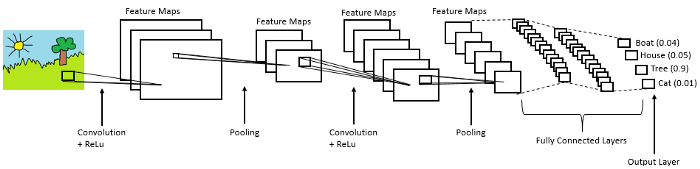


### Convolution

convolution is a mathematical operation on two functions (f and g) 

$$ \begin{align} (f*g)(t) & = \int_{-\infty}^{\infty} f(\tau)g(t-\tau)d\tau \end{align} $$

meaning a weighted average of the function f(τ) at the moment t where the weighting is given by g(–τ) simply shifted by amount t. It is color marked area size in the diagram [demo](https://lpsa.swarthmore.edu/Convolution/CI.html)

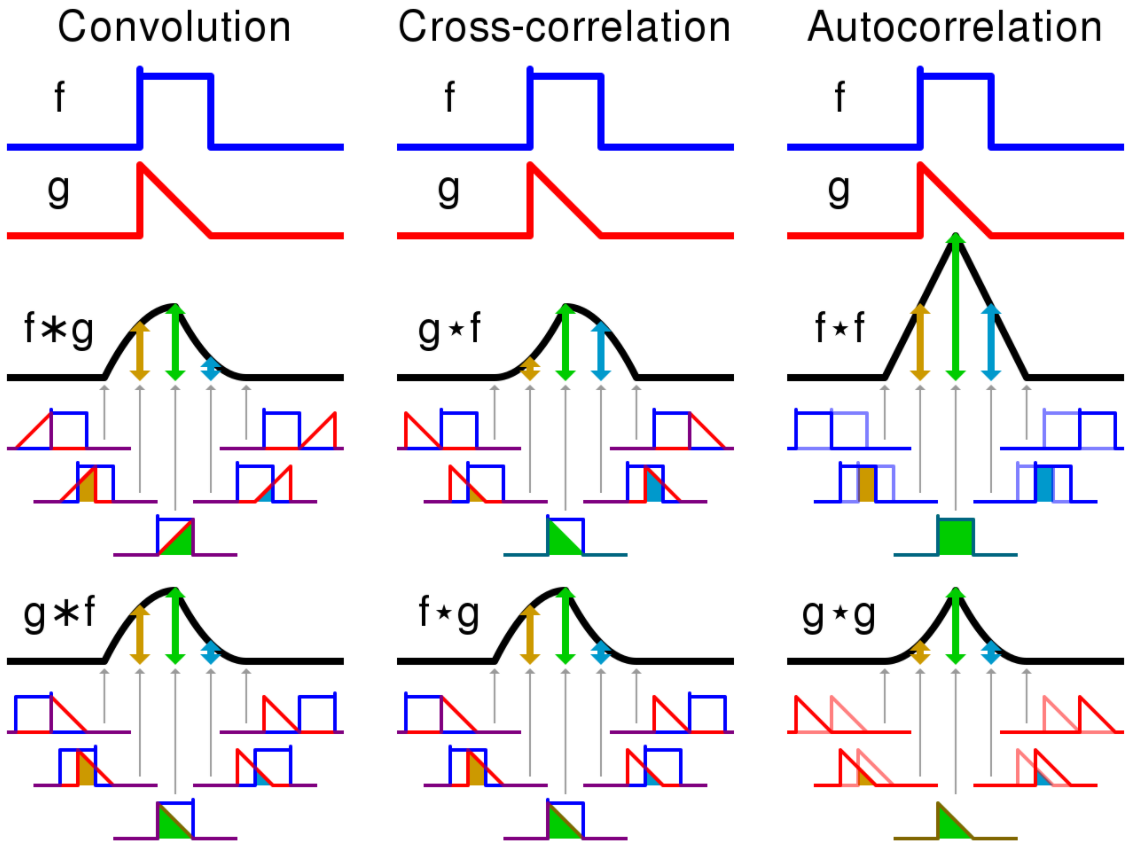

#### important properties

- f * g = g * f
- f * (g * h) = (f * g) * h
- f * (g + h) = f * g + f * h
- D(f * g) = Df * g = f * Dg
- F{f * g} = k.F{f}.F{g}

#### applications

- In digital image processing convolutional filtering plays an important role in many important algorithms in edge detection and related processes.
- In optics, an out-of-focus photograph is a convolution of the sharp image with a lens function. The photographic term for this is bokeh.
- In image processing applications such as adding blurring.
- In statistics, a weighted moving average is a convolution

### Image Techniques

[filter|weights|kernels|features](https://setosa.io/ev/image-kernels/) explained why

## Standard example of handwritten digits recognition (MNIST)

[example](https://towardsdatascience.com/image-classification-in-10-minutes-with-mnist-dataset-54c35b77a38d)

In [2]:
%matplotlib inline
import torch
import torch.nn as nn
import torch.utils.data as Data
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from time import time, sleep
import os
from random import randint

In [2]:
# Hyper-parameters
#
# 28x28 size pixel of an image for input
input_size = 784
# size of middle layers
hidden_size = 500
# output size, characters of 0-9
num_classes = 10

# training parameters
num_epochs = 3
batch_size = 100
learning_rate = 0.001

In [3]:
# Mnist digits dataset
DOWNLOAD_MNIST = False
if not(os.path.exists('./data2/')) or not os.listdir('./data2/'):
    # not mnist dir or mnist is empyt dir
    DOWNLOAD_MNIST = True

# data source
#
# load the data from MNIST dataset to local disk
train_dataset = torchvision.datasets.MNIST(
    root='./data2',
    train=True, 
    transform=transforms.ToTensor(), 
    download=DOWNLOAD_MNIST)
test_dataset = torchvision.datasets.MNIST(
    root='./data2', 
    train=False, 
    transform=transforms.ToTensor())
# Data loader len(train_loader) = 600, so total 600x100 images
train_loader = torch.utils.data.DataLoader(
    dataset=train_dataset, 
    batch_size=batch_size, 
    shuffle=True)
test_loader = torch.utils.data.DataLoader(
    dataset=test_dataset, 
    batch_size=batch_size, 
    shuffle=False)

test_x = torch.unsqueeze(test_dataset.test_data, dim=1).type(torch.FloatTensor)[:2000]/255.   # shape from (2000, 28, 28) to (2000, 1, 28, 28), value in range(0,1)
test_y = test_dataset.test_labels[:2000]
test_x.size(), test_y.size()

/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:60: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:50: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


(torch.Size([2000, 1, 28, 28]), torch.Size([2000]))

torch.Size([60000, 28, 28])
torch.Size([60000])


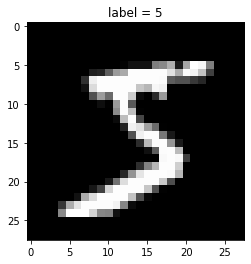

In [4]:
# plot one example
print(train_dataset.data.size())                  # (60000, 28, 28)
print(train_dataset.targets.size())               # (60000)
plt.imshow(train_dataset.data[0].numpy(), cmap='gray')
plt.title('label = %i' % train_dataset.targets[0])
plt.show()


In [5]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(         # input shape (1, 28, 28)
            nn.Conv2d(
                in_channels=1,              # input height
                out_channels=16,            # n_filters
                kernel_size=5,              # filter size
                stride=1,                   # filter movement/step
                padding=2,                  # if want same width and length of this image after con2d, padding=(kernel_size-1)/2 if stride=1
            ),                              # output shape (16, 28, 28)
            nn.ReLU(),                      # activation
            nn.MaxPool2d(kernel_size=2),    # choose max value in 2x2 area, output shape (16, 14, 14)
        )
        self.conv2 = nn.Sequential(         # input shape (1, 28, 28)
            nn.Conv2d(16, 32, 5, 1, 2),     # output shape (32, 14, 14)
            nn.ReLU(),                      # activation
            nn.MaxPool2d(2),                # output shape (32, 7, 7)
        )
        self.out = nn.Linear(32 * 7 * 7, 10)   # fully connected layer, output 10 classes

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.size(0), -1)           # flatten the output of conv2 to (batch_size, 32 * 7 * 7)
        output = self.out(x)
        return output, x    # return x for visualization

cnn = CNN()
print(cnn)  # net architecture


CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=1568, out_features=10, bias=True)
)


### Training

- trained model is saved in file ./mnist

In [6]:
torch.manual_seed(int(time()))
device = torch.device('cpu')

if os.path.isfile("./mnist2"):
    model = torch.load("./mnist2", map_location=lambda storage, loc: storage)
    model.eval()
else:
    model = CNN().to(device)

    # define Loss function and choose optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # Train the model
    n_total_steps = len(train_loader)
    for epoch in range(num_epochs):
        for i, (images, labels) in enumerate(train_loader):
            # loop 600 times, each time with 100 images + labels in a batch.
            #
            # images origin shape: [100, 1, 28, 28]
            # resized: [100, 784] = images is a 100 size batch each with 784 inputs for one image
            #images = images.reshape(-1, 28*28).to(device)
            labels = labels.to(device)

            # Forward pass
            #
            # outputs with shape [100, 10] for the result of 100 size batch, each with output of possibility on 0-9 charactors
            outputs, last_layer = model(images)
            # how likely the predicted in output matches real characters in labels. loss is only one figure as result of a 100 size batch training
            loss = criterion(outputs, labels)

            # Backward and optimize
            #
            # cleanup the history first
            optimizer.zero_grad()
            # dLoss/dWeights
            loss.backward()
            # adjust weights from dLoss/dWeights
            optimizer.step()

            if i % 100 == 0:
                print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i}/{n_total_steps}], Loss: {loss.item():.4f}')

    torch.save(model, "mnist2")

In [7]:
# Test the model
# In test phase, we don't need to compute gradients (for memory efficiency)
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    for images, labels in test_loader:
        #images = images.reshape(-1, 28*28).to(device)
        labels = labels.to(device)
        outputs, last_layer = model(images)
        # max returns (value ,index)
        _, predicted = torch.max(outputs.data, 1)
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()

    acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network on the 10000 test images: {acc} %')

Accuracy of the network on the 10000 test images: 98.8 %


label=7 predicted 7


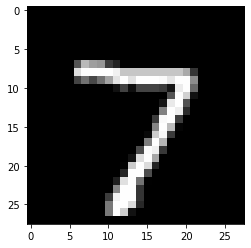

In [8]:
# region debug
data_iter = iter(test_loader)
images, labels = data_iter.next()

#images = images.reshape(-1, 28 * 28).to(device)
labels = labels.to(device)
outputs, last_layer = model(images)
# max returns (value ,index)
_, predicted = torch.max(outputs.data, 1)

images = images.reshape(-1, 28, 28).to(device)
labels_np = labels.numpy()
predicted_np = predicted.numpy()

k = randint(0, 100)
print(f"label={labels_np[k]} predicted {predicted_np[k]}")
plt.imshow(images[k], cmap='gray')
plt.show()
# endregion

In [9]:
print(predicted)
print(labels)

tensor([7, 2, 1, 0, 4, 1, 4, 9, 5, 9, 0, 6, 9, 0, 1, 5, 9, 7, 3, 4, 9, 6, 6, 5,
        4, 0, 7, 4, 0, 1, 3, 1, 3, 4, 7, 2, 7, 1, 2, 1, 1, 7, 4, 2, 3, 5, 1, 2,
        4, 4, 6, 3, 5, 5, 6, 0, 4, 1, 9, 5, 7, 8, 9, 3, 7, 4, 6, 4, 3, 0, 7, 0,
        2, 9, 1, 7, 3, 2, 9, 7, 7, 6, 2, 7, 8, 4, 7, 3, 6, 1, 3, 6, 9, 3, 1, 4,
        1, 7, 6, 9])
tensor([7, 2, 1, 0, 4, 1, 4, 9, 5, 9, 0, 6, 9, 0, 1, 5, 9, 7, 3, 4, 9, 6, 6, 5,
        4, 0, 7, 4, 0, 1, 3, 1, 3, 4, 7, 2, 7, 1, 2, 1, 1, 7, 4, 2, 3, 5, 1, 2,
        4, 4, 6, 3, 5, 5, 6, 0, 4, 1, 9, 5, 7, 8, 9, 3, 7, 4, 6, 4, 3, 0, 7, 0,
        2, 9, 1, 7, 3, 2, 9, 7, 7, 6, 2, 7, 8, 4, 7, 3, 6, 1, 3, 6, 9, 3, 1, 4,
        1, 7, 6, 9])


## How does computer classify the pictures

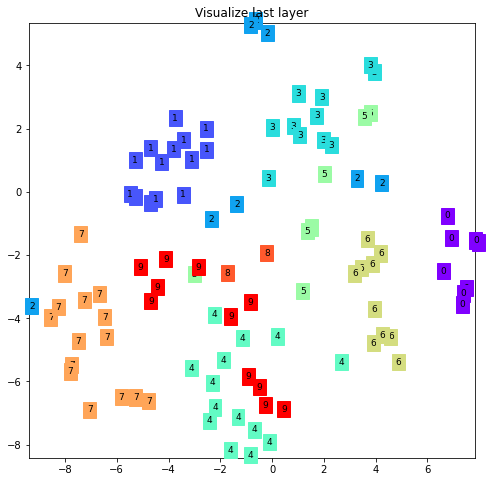

In [10]:
# following function (plot_with_labels) is for visualization, can be ignored if not interested
from matplotlib import cm
from sklearn.manifold import TSNE
def plot_with_labels(lowDWeights, labels):
    plt.cla()
    X, Y = lowDWeights[:, 0], lowDWeights[:, 1]
    for x, y, s in zip(X, Y, labels):
        c = cm.rainbow(int(255 * s / 9)); plt.text(x, y, s, backgroundcolor=c, fontsize=9)
    plt.xlim(X.min(), X.max()); plt.ylim(Y.min(), Y.max()); plt.title('Visualize last layer'); plt.show(); plt.pause(0.01)

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
plot_only = 500
low_dim_embs = tsne.fit_transform(last_layer.data.numpy()[:plot_only, :])   # last_layer from the model output
labels1 = labels.numpy()[:plot_only]                                         # what them represent

fig = plt.figure()
fig.set_figheight(8)
fig.set_figwidth(8)
plot_with_labels(low_dim_embs, labels1)
plt.ioff()